# This notebook is a failed modification of the celeba tutorial

In [1]:
import os
import shutil
import csv
import pickle as pkl
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms 
from PIL import Image

# Process the celeba dataset files

In [10]:
celeb_dir = "/home/ben.gelman/celeba/"
anno_path = celeb_dir + "Anno/list_attr_celeba.txt"
with open(anno_path,'r') as fo:
    counter = 0
    reader = csv.reader(fo, delimiter=' ')
    num_rows = next(reader)
    classes = next(reader)[:-1]
    img_dict = {}
    print(classes)
    for row in reader:
        img_dict[row[0]] = row[1:]

#create a new class
cname = "attractive-brown_hair"
new_dict = {}
attractive_index = classes.index("Attractive")
brown_hair_index = classes.index("Brown_Hair")
for k,v in img_dict.items():
    if (v[attractive_index] == '1') and (v[brown_hair_index] == '1'):
        new_dict[k] = v

new_dir = celeb_dir + cname + '/'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    for k in new_dict.keys():   
        shutil.copy(celeb_dir + 'img_align_celeba/' + k, new_dir)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [82]:
celeb_dir = "/home/ben.gelman/celeba/attractive-brown_hair/"
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = sorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, img_loc.split('/')[-1]
    
dataset = CustomDataSet(celeb_dir, 
                        transform=transforms.Compose([
                            transforms.Resize(32),
                            #transforms.CenterCrop(32),
                            transforms.ToTensor()
                            ])
                        )
dataloader = DataLoader(dataset , batch_size=64, shuffle=True, 
                               num_workers=0, drop_last=True)
'''
dataset=datasets.ImageFolder(
    root=celeb_dir,
    transform=transforms.Compose([
        #transforms.Resize(32),
        #transforms.CenterCrop(32),
        transforms.ToTensor()
        ])
        )

dataloader=DataLoader(dataset,num_workers=0,batch_size=64,shuffle=True)
'''
'''
THE IMAGES ARE 178x218 (WIDExTALL)
'''

'\nTHE IMAGES ARE 178x218 (WIDExTALL)\n'

/home/ben.gelman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


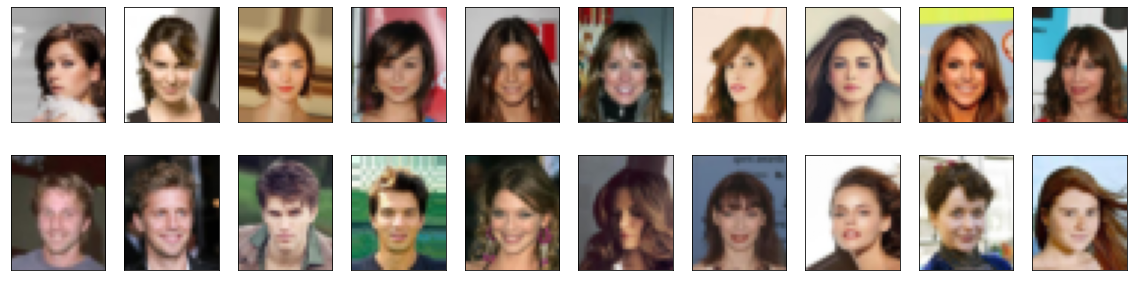

In [83]:
dataiter=iter(dataloader)
#images, labels = dataiter.next()
images, locs = dataiter.next()

def RGBshow(img):
    img=img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))
    
plot_only=20
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
    ax=fig.add_subplot(2,plot_only/2,idx+1,xticks=[],yticks=[])
    RGBshow(images[idx])

In [31]:
print(locs)
#print(len(labels))

('143074.jpg', '117945.jpg', '145939.jpg', '069323.jpg', '006005.jpg', '016940.jpg', '055707.jpg', '059694.jpg', '143308.jpg', '188915.jpg', '108082.jpg', '018088.jpg', '142956.jpg', '109370.jpg', '192544.jpg', '092231.jpg', '110789.jpg', '030713.jpg', '168823.jpg', '181806.jpg', '145689.jpg', '097319.jpg', '183489.jpg', '197563.jpg', '066578.jpg', '126155.jpg', '098315.jpg', '109959.jpg', '041105.jpg', '116801.jpg', '171992.jpg', '193695.jpg')


In [32]:
scaled_img=scale(images[0])
scaled_img.min(),scaled_img.max()

(tensor(-1.), tensor(1.))

In [57]:
def scale(img):
    img=img*2-1
    return img

def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    conv=nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

def deconv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    transpose_conv=nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(transpose_conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self,conv_dim):
        super(Discriminator,self).__init__()
        self.conv_dim=conv_dim

        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        self.conv2=conv(conv_dim,conv_dim*2,4,batch_norm=False)
        self.conv3=conv(conv_dim*2,conv_dim*4,4,batch_norm=False)
        self.conv4=conv(conv_dim*4,conv_dim*8,4,batch_norm=False)

        self.fc=nn.Linear(conv_dim*8*2*2,1)


    def forward(self,x):
        x=F.leaky_relu(self.conv1(x),0.2)
        x=F.leaky_relu(self.conv2(x),0.2)
        x=F.leaky_relu(self.conv3(x),0.2)
        x=F.leaky_relu(self.conv4(x),0.2)
        x = x.view(-1, self.conv_dim*8*2*2)
        out=self.fc(x)
        return out
    
class Generator(nn.Module):
    def __init__(self,z_size,conv_dim):
        super(Generator,self).__init__()
        self.conv_dim=conv_dim
        self.fc = nn.Linear(z_size,conv_dim*8*2*2)

        self.deconv1 = deconv(conv_dim*8,conv_dim*4,4)
        self.deconv2 = deconv(conv_dim*4,conv_dim*2,4)
        self.deconv3 = deconv(conv_dim*2,conv_dim,4)
        self.deconv4 = deconv(conv_dim,3,4,batch_norm=False)

    def forward(self,x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)
        out = F.tanh(x)
        return out


In [58]:
def weights_init_normal(m):

    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Applying initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()

z_size=100
D=Discriminator(32)
G=Generator(z_size,32)

D.apply(weights_init_normal),G.apply(weights_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
    D.cuda()
    G.cuda()

print(f"{D}\n\n\n{G}\n\n\nGPU on:{use_cuda and torch.cuda.is_available()}")

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)


Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [59]:
def real_loss(D_out):
    batch_size = D_out.size(0)
        
    labels = torch.ones(batch_size) * 0.9

    if use_cuda and torch.cuda.is_available():
            labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
        
    labels = torch.ones(batch_size)

    if use_cuda and torch.cuda.is_available():
            labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss    
  
  
d_optimizer = optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))

In [64]:
def train(D, G, n_epochs, print_every=300):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if use_cuda and torch.cuda.is_available():
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if use_cuda and torch.cuda.is_available():
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(dataloader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            
            if use_cuda and torch.cuda.is_available():
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if use_cuda and torch.cuda.is_available():
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if use_cuda and torch.cuda.is_available():
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            # perfom backprop
            g_loss.backward()
            g_optimizer.step()


            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses
  
  

n_epochs = 15

# call training function
losses = train(D, G, n_epochs=n_epochs)
print("Complete!")

/home/ben.gelman/.local/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   15] | d_loss: 0.3619 | g_loss: 0.5393
Epoch [    1/   15] | d_loss: 0.4583 | g_loss: 0.3253
Epoch [    1/   15] | d_loss: 0.4613 | g_loss: 0.3252
Epoch [    2/   15] | d_loss: 0.8715 | g_loss: 3.7124
Epoch [    2/   15] | d_loss: 0.4682 | g_loss: 0.3271
Epoch [    2/   15] | d_loss: 0.3862 | g_loss: 0.3551
Epoch [    3/   15] | d_loss: 0.4003 | g_loss: 0.4238
Epoch [    3/   15] | d_loss: 0.4400 | g_loss: 0.3694
Epoch [    3/   15] | d_loss: 0.3908 | g_loss: 0.4434
Epoch [    4/   15] | d_loss: 0.4836 | g_loss: 0.3321
Epoch [    4/   15] | d_loss: 0.4463 | g_loss: 0.3253
Epoch [    4/   15] | d_loss: 0.4329 | g_loss: 0.3467
Epoch [    5/   15] | d_loss: 0.4093 | g_loss: 0.3562
Epoch [    5/   15] | d_loss: 0.4099 | g_loss: 0.3613
Epoch [    5/   15] | d_loss: 0.3856 | g_loss: 0.4366
Epoch [    6/   15] | d_loss: 0.4383 | g_loss: 0.3504
Epoch [    6/   15] | d_loss: 0.4104 | g_loss: 0.3726
Epoch [    6/   15] | d_loss: 0.4152 | g_loss: 0.3616
Epoch [    7/   15] | d_loss

16


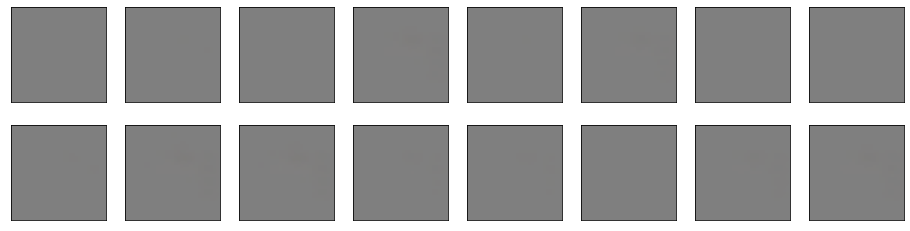

In [95]:
sample_size=16
'''
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
'''
fixed_z = torch.randn(sample_size,z_size)
fixed_z = fixed_z.cuda()
G.eval()
examples = G(fixed_z)
print(len(examples))

fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), examples):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img)

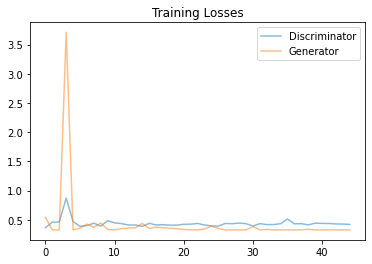

In [65]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

tensor([ 5.3977e-04,  3.9768e-04, -3.5682e-04,  3.6991e-04,  1.8538e-04,
        -3.5952e-06, -3.1464e-06, -3.8822e-06, -4.1525e-06, -2.7712e-06,
        -2.3588e-05, -2.0652e-05, -3.8896e-05, -1.8364e-05, -1.4333e-05,
         0.0000e+00,  0.0000e+00, -1.8912e-06, -1.1290e-05, -9.6544e-06,
        -1.6575e-05, -9.1512e-06, -1.6811e-05, -1.2605e-05, -3.4801e-05,
        -3.6074e-05, -7.3298e-05, -4.5464e-05, -6.2620e-05, -3.6048e-05,
        -1.1452e-04, -6.9650e-05], device='cuda:0', grad_fn=<SelectBackward>)


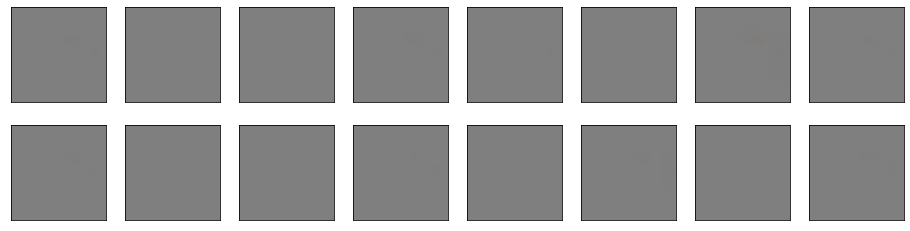

In [81]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img)
        im = ax.imshow(img.reshape((32,32,3)))
        

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    print(samples[-1][0][0][0])
_ = view_samples(-1, samples)